**Exercise lecture 1 (Mateus Dias Ribeiro)**

**Download Tobacco-3482 dataset:**

For this exercise lecture, we are going to use a Deep Convolutional Architecture (AlexNet) to perform a classification task on the Tobbaco-3482 legistlation dataset. This dataset contains documents regarding information about the Tobacco industry in 10 different classes:

0 Ad
1 Email
2 Form
3 Letter
4 Memo
5 News
6 Note
7 Report
8 Resume
9 Scientific


![A few samples of the Tobacco-3482 dataset](https://drive.google.com/uc?export=download&id=11VP9e0YRZ321Rrpjq1suiJlONFh7pka8)

Our goal here is to use Keras to replicate the results obtained in this paper: 

**M. Z. Afzal et al., "Deepdocclassifier: Document classification with deep Convolutional Neural Network," 2015 13th International Conference on Document Analysis and Recognition (ICDAR), Tunis, 2015, pp. 1111-1115.
doi: 10.1109/ICDAR.2015.7333933**

In that paper, the authors used the AlexNet architecture with pre-trained weights obtained from training the network on the ImageNet dataset and have shown that transfer learning can be very useful to drastically reduce the number of necessary training samples.

The original dataset can be downloaded here: https://lampsrv02.umiacs.umd.edu/projdb/project.php?id=72.

To start, let's download the dataset:




In [ ]:
!wget http://lampsrv02.umiacs.umd.edu/projdb/edit/userfiles/datasets/Tobacco3482_1.zip
!wget http://lampsrv02.umiacs.umd.edu/projdb/edit/userfiles/datasets/Tobacco3482_2.zip

In [ ]:
!unzip Tobacco3482_1.zip
!unzip Tobacco3482_2.zip

In [1]:
ls

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 9497-E106

 C:\Users\Yunmin\Applications of Machine Learning and Data Science Exercise\01_DeepDocClassEx_MateusDiasRibeiro 디렉터리

2020-12-21  오후 03:01    <DIR>          .
2020-12-21  오후 03:01    <DIR>          ..
2020-12-16  오후 03:46    <DIR>          .ipynb_checkpoints
2020-12-21  오후 03:01               800 data.h5
2020-12-21  오후 03:01           932,378 deepDocClassifierEx_MDR.ipynb
2020-12-21  오후 02:50         1,032,615 deepDocClassifierEx_MDR_Answers.ipynb
2020-12-21  오후 02:00    <DIR>          supplementary
2020-12-17  오후 11:48    <DIR>          Tobacco3482-jpg
               3개 파일           1,965,793 바이트
               5개 디렉터리  75,613,831,168 바이트 남음


**Exercise 1:**

We need to convert the dataset from the image format (.tiff) into a format that can be imported to our python script so that we can feed it to a neural network. In addition, we also have to create a vector assigning an integer to each class, which is going to act as labels. For example, "0" for advertisement, "1" for email, "2" for form, etc. For this exercise, create a script to convert the input images from .tiff into the hdf5 format. For convenience, save only 100 samples for each of the 10 classes. You should also specify a resolution of 227 pixels in both x and y directions. That means that the final dimension of your dataset will be 1000 (samples) x 227 x 227 (image resolution).

In [12]:
##########################
##### Your code here #####
##########################

import os
from PIL import Image
import h5py
import numpy as np

ls_labels = [ 'ADVE', 'Email' , 'Form' , 'Letter' , 'Memo' , 'News' , 'Note' , 'Report', 'Resume' ,'Scientific'  ]


count_1000 = 0
train_x = np.zeros((1000,227,227))
train_y = np.ones((1000, 1))

for(path, dir, files) in os.walk("Tobacco3482-jpg\\"):
    count_100 = 0
    for filename in files:
        if (count_100 == 100) or (count_1000 == 1000):
            break
        ext = os.path.splitext(filename)[-1]
        if ext == '.jpg':
            #print("%s\\%s" %(path, filename))
            image = Image.open(path + '\\' + filename)
            image_resize = image.resize((227, 227))
            train_x[count_1000,:,:] = image_resize
            train_y[count_1000,:] = int(count_1000/100)
            count_100 += 1
            count_1000 += 1

h5_tr_x = h5py.File('train_x.h5', 'w')
h5_tr_x.create_dataset('train_x', data=np.array(train_x))
print(h5_tr_x)
h5_tr_x.close()

h5_tr_y = h5py.File("train_y.h5", 'w')
h5_tr_y.create_dataset("train_y", data=np.array(train_y))
print(h5_tr_y)
h5_tr_y.close()

<HDF5 file "train_x.h5" (mode r+)>
<HDF5 file "train_y.h5" (mode r+)>


We also need to download some supplementary files, including convnets and pre-trained imagenet weights.

The credit for this goes to heuritech: https://github.com/heuritech/convnets-keras

In [13]:
!git clone https://git.opendfki.de/mateus.dias_ribeiro/supplementary.git


fatal: destination path 'supplementary' already exists and is not an empty directory.


Now, let's import necessary dependencies (ignore it if you get warnings about outdated Tensorflow version).

In [14]:
import numpy as np
import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
import pickle
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix
import itertools
from supplementary.convnetskeras.customlayers import splittensor
from keras.layers import concatenate
from keras import backend as K

Load the dataset to the environment and make necessary adaptations. For example, the figures of the dataset are in black and white (1 gray-scale channel), but the AlexNet architecture expects an input with 3 channels (RGB). Therefore we need to stack copies of each sample of the dataset three by three in order to follow these requirements.

Furthermore, the dataset dimensions follow the rule (Ns, Nc, Nx, Ny), in which:

Ns: Number of samples = 1000

Nc: Number of channels = 3 (after adaptation)

Nx: Number of horizontal points = 227

Ny: Number of vertical points = 227

Therefore, we have to tell the Keras environment that the dimension "number of channels" comes first in regard to the 2D x-y pixels.

In a last step, we shuffle the dataset. Shuffling the dataset can improve the training performance.

In [15]:
# Convert hdf5 to array
with h5py.File('./train_x.h5', 'r') as f:
    train_x = f['train_x'][()]

with h5py.File('./train_y.h5', 'r') as f:
    train_y = f['train_y'][()]

In [16]:
train_x.shape, train_y.shape

((1000, 227, 227), (1000, 1))

In [17]:
# Tell Keras to use first dimension of the tensor for the number of channels
K.set_image_data_format('channels_first')

# Loading figures in the dataset
# AlexNet assumes input with 3 channels (RGB). Since the figures of the Tobbaco
# dataset are grey-scale (1 black/white channel), we stack three copies of each
# figure for each sample of our input data
data_x = np.zeros((1000,3,227,227))
data_x[:,0,:,:] = train_x[:,:,:]
data_x[:,1,:,:] = train_x[:,:,:]
data_x[:,2,:,:] = train_x[:,:,:]

# Loading labels of the dataset
# 0 Ad
# 1 Email
# 2 Form
# 3 Letter
# 4 Memo
# 5 News
# 6 Note
# 7 Report
# 8 Resume
# 9 Scientific
data_y = train_y[:,:]

# Shuffling dataset
indices = np.arange(1000)
np.random.shuffle(indices)
data_x = data_x[indices,:,:,:]
data_y = data_y[indices,:]

First, let's plot a random sample of each class:

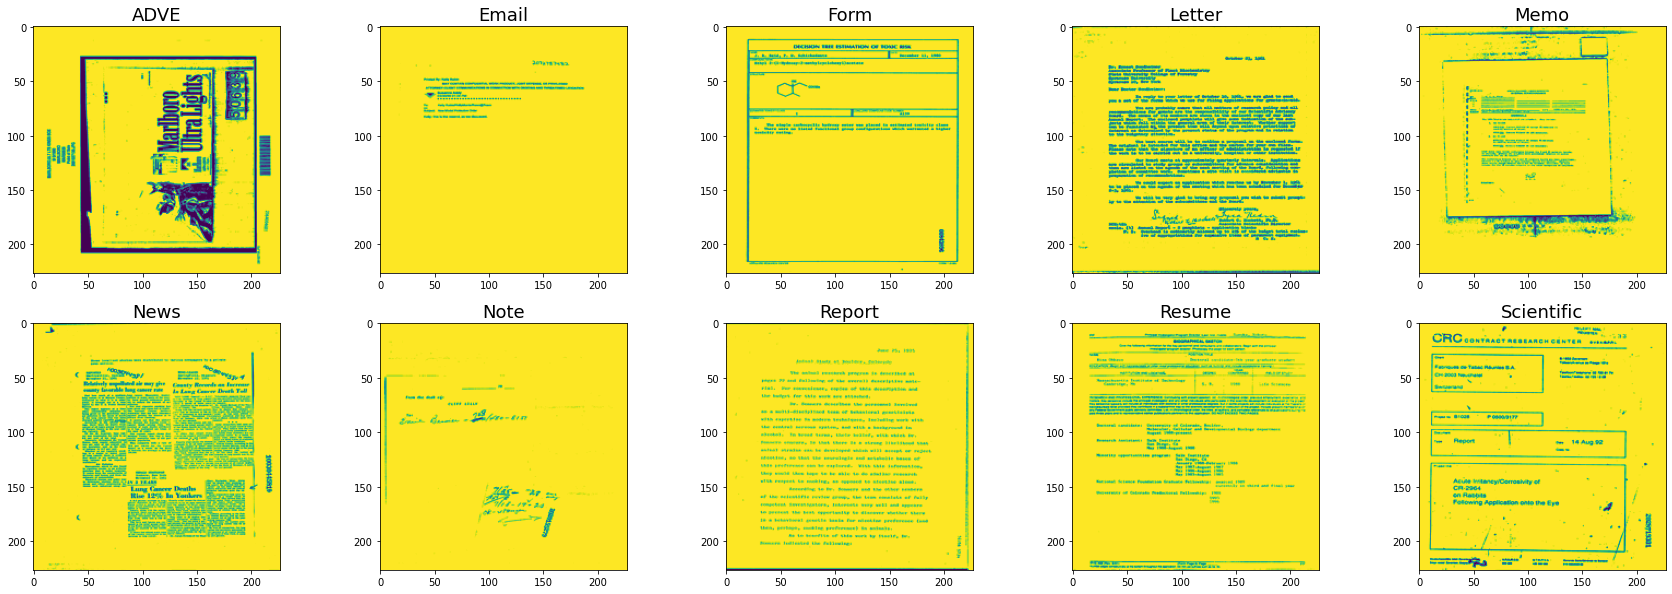

In [18]:
lsy = []
for i in range(10):
    ind = np.where( data_y[:] == i)
    lsy.append(ind[0])

plt.figure()
fig = plt.gcf()
fig.set_size_inches(30, 10)
for i in range(2):
    for j in range(1,6):
        plt.subplot(2, 5, 5*i+j)
        plt.title(str(ls_labels[5*i+j-1]), fontsize=18) 
        imshow(data_x[lsy[5*i+j-1][np.random.randint(100)],0])
plt.show()

Now let's create some data train/test splits:

1) 200 (train) / 800 (test) - 20 samples per class for training

2) 400 (train) / 600 (test) - 40 samples per class for training

3) 600 (train) / 400 (test) - 60 samples per class for training

4) 800 (train) / 200 (test) - 80 samples per class for training

In [19]:
img_rows, img_cols = 227, 227
num_classes = 10

lim = 800    #200  400  600 800
x_train = data_x[0:lim,:,:]
x_test = data_x[lim:1000,:,:]

y_train = data_y[0:lim,:]
y_test = data_y[lim:1000,:]

tr_sz = lim
ts_sz = 1000 - lim

x_train = x_train.reshape(tr_sz,3,img_rows,img_cols)
x_test =  x_test.reshape(ts_sz,3,img_rows,img_cols)

# convert class vectors to binary class matrices(one hot vector)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

**AlexNet architecture**

At this point, we are ready to define our Deep CNN architecture (AlexNet) using Keras. There is one important observation about the code in the next cell. The convolutional layers with highest number of parameters have been split in 2. We need to do this because this was also done in the architecture used to pre-train the weights on the ImageNet dataset. The main motivation for such a setup was that two GPUs were used for training, and splitting the parameters equally between them can improve parallelization efficiency. Even though this is likely not our case (unless you have two GPUs for the training), we need to do the same because the weights of our architecture need to be consistent with the pre-trained weights, so that transfer learning can be employed.

In [26]:
def DeepDoc(weights_path=None):

    inputs = Input(shape=(3, 227, 227))

    conv_1 = Conv2D(96, (11, 11), strides=(4, 4), activation='relu', name='conv_1')(inputs)
    max_1 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1)
    pad_1 = ZeroPadding2D((2, 2))(max_1)

    conv_2 = concatenate([
                      Conv2D(128, (5, 5), activation='relu', name='conv_2_' + str(i + 1))(
                          splittensor(ratio_split=2, id_split=i)(pad_1)
                      ) for i in range(2)], axis=1, name='conv_2')
    max_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2)
    pad_2 = ZeroPadding2D((1, 1))(max_2)
    
    conv_3 = Conv2D(384, (3, 3), activation='relu', name='conv_3')(pad_2)
    pad_3 = ZeroPadding2D((1, 1))(conv_3)
    
    conv_4 = concatenate([
                       Conv2D(192, (3, 3), activation='relu', name='conv_4_' + str(i + 1))(
                           splittensor(ratio_split=2, id_split=i)(pad_3)
                       ) for i in range(2)], axis=1, name='conv_4')
    pad_4 = ZeroPadding2D((1, 1))(conv_4)
    
    conv_5 = concatenate([
                       Conv2D(128, (3, 3), activation='relu', name='conv_5_' + str(i + 1))(
                           splittensor(ratio_split=2, id_split=i)(pad_4)
                       ) for i in range(2)], axis=1, name='conv_5')
    max_5 = MaxPooling2D((3, 3), strides=(2, 2), name='convpool_5')(conv_5)

    fc_0 = Flatten(name='flatten')(max_5)
    fc_0 = Dropout(0.2)(fc_0)
    fc_1 = Dense(4096, activation='relu', name='dense_1')(fc_0)
    fc_1 = Dropout(0.2)(fc_1)
    fc_2 = Dense(4096, activation='relu', name='dense_2')(fc_1)
    fc_2 = Dropout(0.2)(fc_2)
    out = Dense(10, name='dense_out')(fc_2)
    prediction = Activation('softmax', name='softmax_out')(out)

    model = Model(inputs, prediction)

    # If pre-trained weights are provided, we add them to the network at this step
    if weights_path:
        model.load_weights(weights_path, by_name=True)

    return model

**Exercise 2:**

Use the formulas presented in the class to answer how many ***parameters*** there are in the following parts of the model (tip: don't forget the bias):

a) conv_1

b) conv_3

c) max_2

d) max_5

e) fc_1

f) fc_2

**Exercise 3:**

In addition, calculate how many ***activations*** we will have in each of the parts of exercise 3:

a) conv_1

b) conv_3

c) max_2

d) max_5

e) fc_1

f) fc_2

**Exercise 4:**

Please explain what the following parts of the code are and what purpose do they serve?

a) *activation='relu'*

b) *Dropout(0.5)*

c) *Flatten(name='flatten')*

d) *MaxPooling2D*

e) *Activation('softmax', name='softmax_out')*

**Train model**

We can now finally go ahead and train the model. A few important remarks:

In the first line we call the architecture we defined above ("DeepDoc") and assign it to an object called "deepDoc". During this call, we input the path of the pre-trained weights in order to leverage from the parameters learned on the ImageNet dataset. This action is known as "transfer learning". If we wish to train the model without transfer learning, we can simply call the model and leave the input empty, such as in:

*deepDoc = DeepDoc()*

We also need to define the hyper-parameters of the model. We are using a *batch size* of 10, which means that we perform forward and back propagation in groups or mini batches of 10. The choice of mini batch size needs to be carefully chosen, especially for big datasets. On one hand, we normally don't want to use huge batches, such as the entire dataset, because of memory constraints (especially running on GPUs) and/or because this may give the optimizer a hard time. On the other hand, we also don't want to use very small batches, such as 1 because it would not be very efficient. The optimizer would have to work too many repeated times (Epochs).

For optimization of the parameters, we use the Stochastic Gradient Descent algorithm, together with weight decay and momentum. A straight forward explanation was given in https://stats.stackexchange.com/questions/70101/neural-networks-weight-change-momentum-and-weight-decay, which we reproduce here. One step of gradient descent has the following form:

\begin{equation}
\Delta\omega_i(t+1) = - \eta\frac{\partial E}{\partial w_i} + \alpha \Delta \omega_i(t) - \lambda\eta\omega_i
\end{equation}

in which $\eta$ is the learning rate, $E(w)$ is the cost function, and $w$ the tensor of weights. Momentum $\alpha$ is used to diminish the fluctuations in weight changes over consecutive iterations, and weight decay $\lambda$ penalizes the weight changes. 

One way to think about it is that weight decay changes the function that's being optimized, while momentum changes the path you take to the optimum. Weight decay, by shrinking your coefficients toward zero, ensures that you find a local optimum with small-magnitude parameters. This is usually crucial for avoiding overfitting (although other kinds of constraints on the weights can work too). As a side benefit, it can also make the model easier to optimize, by making the objective function more convex. 

Once you have an objective function, you have to decide how to move around on it. Steepest descent on the gradient is the simplest approach, but fluctuations can be a big problem. Adding momentum helps solve that problem. If you're working with batch updates (which is usually a bad idea with neural networks) Newton-type steps are another option. The new "hot" approaches are based on Nesterov's accelerated gradient and so-called "Hessian-Free" optimization.

Finally, we run the training loop for a total of 50 iterations (epochs), and we use the categorical cross-entropy loss function. We input our train dataset (x_train and y_train), as well as our testset (x_test and y_test) to the fit function of our deepDoc object from our DeepDoc model class. We use the metric "accuracy" on the testset to evaluate how well our model is performing.

**Exercise 5:**

Train the model by executing the next cell using all the four splits you created before. Report the accuracy on the testset for each of these runs.

In [27]:
deepDoc = DeepDoc('./supplementary/trainedWeights/alexnet_weights.h5')
#deepDoc = DeepDoc()

batch_size = 10
epochs = 50  #100  50  30

deepDoc.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.0001, decay=0.0005, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

deepDoc.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = deepDoc.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50


InvalidArgumentError:  Default MaxPoolingOp only supports NHWC on device type CPU
	 [[node model_1/max_pooling2d_2/MaxPool (defined at <ipython-input-27-b4b5e65d4ca8>:11) ]] [Op:__inference_train_function_3217]

Function call stack:
train_function


**Exercise 6:**

In order to have a better intuition of the performance of the model on the testset, we can use a little bit of a visual aid by plotting the so called "confusion matrix". Create a confusion matrix such as the one shown in the second theory class:

In [ ]:
##########################
##### Your code here #####
##########################

**Exercise 7:**

About the confusion matrix plotted above, answer the following questions:

a) What do the vertical and horizontal axis mean?

b) What are the highest accuracies obtained and for which labels?

c) What are the lowest accuracies obtained and for which labels?

d) What are, in your opinion, the reasons for missclassification in these classes?

**Exercise 8:**

Try training the model again for the last split (800/200), but this time without using transfer learning. In this case you should do the following call:

deepDoc = DeepDoc()

What happens to the accuracy in this case?